In [75]:
import scipy.stats as sts
import numpy as np

import matplotlib.pyplot as plt

# Problem 1: Posterior Predictive Checks

For the non-hierarchical model and the control group half of the data set, choose a test statistic to show that the non-hierarchical model does not explain the control group data well.

## Model Summary

This model assumes a fixed probability of success across each control groups $\theta_{c}$ with uniform prior, a binomial model for data, summarized below. `studies` denotes the sample sizes `n` for each study, while `results` denotes the observed improvements we will benchmark against. The Posterior over $\theta_{c}$ is $\text{Beta}(\theta_{c} | 58, 65)$,

In [117]:
studies = np.array([15, 18, 10, 39, 29, 10])
outcomes = np.array([9, 11, 4, 21, 12, 0])

posterior_alpha = 58
posterior_beta = 65

# frozen Posterior Dist
posterior_control = sts.beta(posterior_alpha, posterior_beta)

We will now draw 10,000 samples from the Beta posterior and generate posterior predictives. The procedure is simple: we simulate a replication of the 6 experiments by seeding 6 binomial likelihoods with the $\theta_{c}$ sample and sample sizes $n_1 ... n_6$ according to the original study size,

In [211]:
# Posterior Predictive Samples
n = 10000
# Arrays for simulated experiment replications
samples = np.zeros(
    (n, len(studies)),
    dtype = np.float16)

tests = np.zeros(
    (n, len(studies)),
    dtype = np.float16)

for experiment in range(n):
    # Draw theta by sampling posterior
    theta_control = posterior_control.rvs()

    # Simulate an experiment replication, for each study
    for i,study_size in enumerate(studies):

        outcome = sts.binom.rvs(study_size, theta_control)
        
        # Save result
        samples[experiment][i] = outcome

We have 4 candidate test statistics: these are scalar summaries between two sets of distributions, the observed data and the data replicated in the posterior predictive. To calculate each p-value, we count the number of times the sample statistic is greater than the 'true' test statistic (calculated just once over the observed values),

In [141]:
def test_stat(data, stat, **kwargs):
    # Compute test stat(str) over data(array) 
    stats = {
        'Mean': np.mean,
        'Std': np.std,
        'Range': np.ptp,
        'Total': np.sum
    }

    return stats[stat](data, **kwargs)

def test(samples, data, stat):
    # Test model given samples(matrix), observed data (arr)
    # and test stat(str)

    # Compute test stat
    benchmark = test_stat(data, stat)
    stats = test_stat(samples, stat, axis = 1)
    
    # Compute p-val
    p_val = sum(stats > benchmark)/len(stats)

    return p_val, benchmark, stats


A clean visual summary can be found in the plot below,

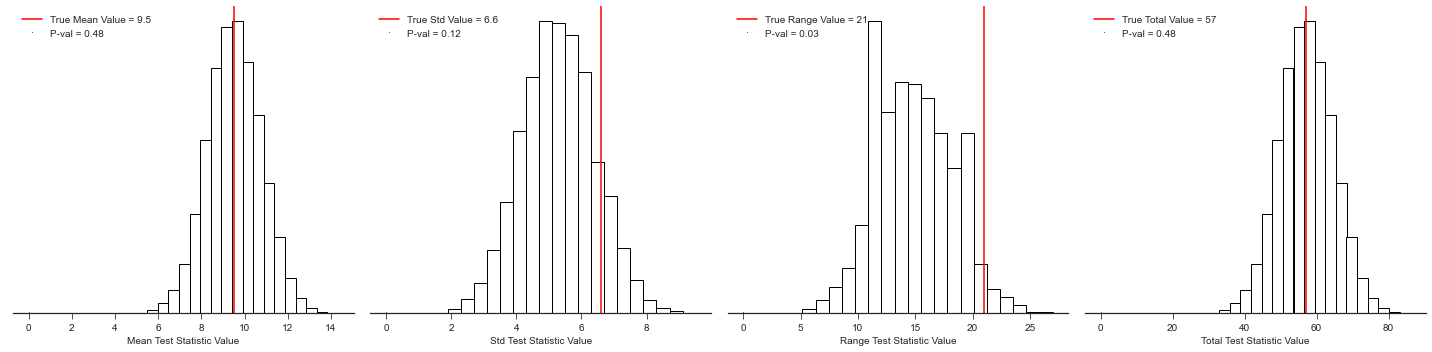

In [216]:
stats = ['Mean', 'Std', 'Range', 'Total']

fig, axs = plt.subplots(1,len(stats), figsize = (5*len(stats), 5))

for ax, stat in zip(axs.flat, stats):
    post_hist(samples, outcomes, stat, ax = ax)

plt.show()

Mean, Total and Standard Deviatio statistics are normally-distributed according to the CLT (both represent linear sums in IID random variables), with a p-value of 0.47, suggesting that the model predicts the mean improvement rate well, as a non-hierarchical model assuming constant improvement rates accross studies should. 

The standard deviation, on the other hand, has a p-value of 0.12, suggesting that a the model under-predicts the spread in the number of improved patients in the control group. 

The range has a p-value of 0.03, suggesting that the model severely overestimates the range of the distribution of control-group patient outcomes. In other words, extrema are not well modeled. 

# Technical Appendix

In [215]:
# Technical Appendix

def post_hist(
    samples,
    data,
    stat = 'mean',
 
    ax = False,
    bins=20, 
    color='w', 
    edgecolor='k', 
    figsize=(5,3), 
    ):

    
    plt.style.use('seaborn-ticks')
    
    if ax == False:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
        
        p_val, benchmark, x = test(
            samples,
            data,
            stat)
        
        ax.hist(
            x, 
            bins=bins, 
            color = color, 
            edgecolor = edgecolor)

        ax.axvline(
            benchmark,
            color = 'red',
            label = f'True {stat} Value = {round(benchmark,2)}'
        )

        ax.plot(
            0,0,',',
            label = f'P-val = {round(p_val,2)}')

        adjust_spines(ax, ['bottom'])
        ax.set_xlabel(f'{stat} Test Statistic Value')
        ax.legend(loc = "best")

        plt.tight_layout()

    else:
        p_val, benchmark, x = test(
            samples,
            data,
            stat)
        
        ax.hist(
            x, 
            bins=bins, 
            color = color, 
            edgecolor = edgecolor)

        ax.axvline(
            benchmark,
            color = 'red',
            label = f'True {stat} Value = {round(benchmark,2)}'
        )

        ax.plot(
            0,0,',',
            label = f'P-val = {round(p_val,2)}')

        adjust_spines(ax, ['bottom'])
        ax.set_xlabel(f'{stat} Test Statistic Value')
        ax.legend(loc = "upper left")

        plt.tight_layout()
        


def adjust_spines(ax, spines, offset = 0):
        for loc, spine in ax.spines.items():
            if loc in spines:
                spine.set_position(('outward', offset))  # outward by offset points
                #spine.set_smart_bounds(True)
            else:
                spine.set_color('none')
        # turn off ticks where there is no spine
        if 'left' in spines:
            ax.yaxis.set_ticks_position('left')
        else:
            # no yaxis ticks
            ax.yaxis.set_ticks([])

        if 'bottom' in spines:
            ax.xaxis.set_ticks_position('bottom')
        else:
            # no xaxis ticks
            ax.xaxis.set_ticks([])